# Proyecto Final Algebra Lineal 2017
---

El proyecto del curso consiste en la implementación del [Algortimo de Canny](https://es.wikipedia.org/wiki/Algoritmo_de_Canny) para la detección de bordes en imágenes y videos. Para ello, se le entrega al estudiante toda la implementación del algoritmo en [OpenCV](http://opencv.org/) y su objetivo es **implementar las funciones de OpenCV con matrices**. 

Las funciones a modificar serán las siguientes:
```python
cv2.GaussianBlur()
cv2.Sobel()
```

No es necesario que modifique más del código que se le solicita, pero puede hacer las modificaciones pertinentes si ese fuera el caso. Dentro del código se le indica en qué parte debe de ser modificado, por ejemplo:

```python
'''Modificar esta función'''
    sobel = cv2.Sobel(img, cv2.CV_64F, x, y, ksize=sobel_kernel)
``` 

Se recomienda buscar maneras de optimizar los cálculos de sus filtros, pues más adelante existe una aplicación en tiempo real donde es crucial que sus cálculos sean lo más rápidos posibles. Las dimensiones de los *kernels* no pueden ser modificadas.

## 0. Conceptos
Para poder modificar las funciones solicitadas es necesario que comprenda algunos conceptos, por lo cual es necesario que defina:

1. ¿En que consiste la convolución y cómo puede ser calculada? (Puede dar una definición matemática y/o ejemplos).

2. ¿Qué es el *kernel* de un filtro y para que se utiliza?

3. ¿En qué consiste un filtro Gaussiano?

4. ¿En qué consiste el Filtro Sobel? ¿para qué sirve?

3. Describa el algoritmo de detección de bordes Canny.

In [1]:
import numpy as np
import matplotlib.pylab as plt
import cv2

from moviepy.editor import VideoFileClip
from IPython.display import HTML
from PIL import Image
import math

%matplotlib inline

In [ ]:
def gauss_blur(img, r):
    image = img

    # do-it-yourself convolution:
    # For each pixel in the input image, we'll inspect its neighborhood. A 3x3 kernel thus peeks
    # at every neighbor of a specific pixel (there are 8 pixel neighbors) whereas a 5x5 kernel
    # peeks at two pixels in every direction (i.e. 24 pixel neighbors).

    # A kernel of all ones is called a box blur and is simply averaging all neighbors (sum all, optionally divide by count).
    kernel = np.array([[1, 2, 1],
                    [2, 8, 2],
                    [1, 2, 1]],dtype=np.float)

    # the weighed pixels have to be in range 0..1, so we divide by the sum of all kernel
    # values afterwards
    kernel_sum = kernel.sum()

    # fetch the dimensions for iteration over the pixels and weights
    i_width, i_height = image.shape[0], image.shape[1]
    k_width, k_height = kernel.shape[0], kernel.shape[1]

    # prepare the output array
    filtered = np.zeros_like(image)

    # Iterate over each (x, y) pixel in the image ...
    for y in range(i_height):
        for x in range(i_width):
            weighted_pixel_sum = 0

            # Iterate over each weight at (kx, ky) in the kernel defined above ...
            # We interpret the kernel weights in a way that the 'central' weight is at (0, 0);
            # so the coordinates in the kernel are:
            #
            #  [ (-1,-1),  (0,-1),  (1,-1)
            #    (-1, 0),  (0, 0),  (1, 0)
            #    (-1, 1),  (0, 1),  (1, 1)
            #
            # This way, the pixel at image[y,x] is multiplied with the kernel[0,0]; analogous,
            # image[y-1,x] is multiplied with kernel[-1,0] etc.
            # The filtered pixel is then the sum of these, so that
            #
            #   weighted_pixel_sum = image[y-1,x-1] * kernel[-1,-1] +
            #                        image[y-1,x  ] * kernel[-1, 0] +
            #                        image[y-1,x+1] * kernel[-1, 1] +
            #                        image[y,  x-1] * kernel[ 0, 1] +
            #                        image[y,  x  ] * kernel[ 0, 0] +
            #                        etc.

            for ky in range(-(k_height / 2), k_height - 1):
                for kx in range(-(k_width / 2), k_width - 1):
                    pixel = 0
                    pixel_y = y - ky
                    pixel_x = x - kx

                    # boundary check: all values outside the image are treated as zero.
                    # This is a definition and implementation dependent, it's not a property of the convolution itself.
                    if (pixel_y >= 0) and (pixel_y < i_height) and (pixel_x >= 0) and (pixel_x < i_width):
                        pixel = image[pixel_y, pixel_x]

                    # get the weight at the current kernel position
                    # (also un-shift the kernel coordinates into the valid range for the array.)
                        weight = kernel[ky + (k_height / 2), kx + (k_width / 2)]

                    # weigh the pixel value and sum
                    weighted_pixel_sum += pixel * weight

            # finally, the pixel at location (x,y) is the sum of the weighed neighborhood
            filtered[y, x] = weighted_pixel_sum / kernel_sum
    return filtered

In [ ]:
    def gauss_blur(img, r):
        imgData = list(img.getdata())

        bluredImg = Image.new(img.mode, img.size)
        bluredImgData = list(bluredImg.getdata())

        rs = int(math.ceil(r * 2.57))

        for i in range(0, img.height):
            for j in range(0, img.width):
                val = 0
                wsum = 0
                for iy in range(i - rs, i + rs + 1):
                    for ix in range(j - rs, j + rs + 1):
                        x = min(img.width - 1, max(0, ix))
                        y = min(img.height - 1, max(0, iy))
                        dsq = (ix - j) * (ix - j) + (iy - i) * (iy - i)
                        weight = math.exp(-dsq / (2 * r * r)) / (math.pi * 2 * r * r)
                        val += imgData[y * img.width + x] * weight
                        wsum += weight 
                bluredImgData[i * img.width + j] = round(val / wsum)

        bluredImg.putdata(bluredImgData)
    return bluredImg

In [ ]:
def convolve(A, k):
    r,c = A.shape
    m,n = k.shape
    h = np.rot90(k, 2)
    centerR = (m+1)/2
    centerC = (m+1)/2
    left = centerC - 1
    right = n - centerC
    top = centerR - 1
    bottom = m - centerR
    Rep = np.zeros((r + top + bottom, c + left + right),dtype=np.uint8)
    for x in range(1+top, r +top):
        for y in range(1+left, c + left):
            Rep[x,y] = A[x - top, y - left]
    B = np.zeros((r , c),dtype=np.uint8)
    print r,c,m,n,B.shape[0],B.shape[1],Rep.shape[0],Rep.shape[1]
    for x in range(0,r):
        for y in range(0,c):
            for i in range(0,m):
                for j in range(0,n):                    
                     B[x, y] = B[x, y] + (Rep[i + x, j + y] * h[i, j])
                    
    return B

In [29]:
def Mygauss_blur(img):
    
    kernel = np.array([[1,2,3,2,1],
                       [2,7,11,7,2],
                       [3,11,17,11,3],
                        [2,7,11,7,2],
                        [1,2,3,2,1]],dtype=np.float)
    r= img.shape[0]
    c= img.shape[1]
    #gauss = np.zeros((r, c), dtype=np.uint8)
    
    kernel = kernel / 121
    
    for i in range(1, r - len(kernel)+1):
        for j in range(1, c - len(kernel)+1):
            
            img[i][j]=(kernel*img[i:i+len(kernel),j:j+len(kernel)]).sum()
                #signal_patch=img[i:i+len(kernel),j:j+len(kernel)]   
                #gauss[i][j]=(kernel*signal_patch).sum()
            
            '''[1,2,3,2,1],
                       [2,7,11,7,2],
                       [3,11,17,11,3],
                        [2,7,11,7,2],
                        [1,2,3,2,1]]
            [1, 2, 1],
            [2, 8, 2],
            [1, 2, 1]]
    img=convolve(A=img,k=kernel)'''
           
    return img
 


In [30]:
def Mysobel_fun(img, orient='x'):
    # Calculate directional gradient
    r,c=img.shape
    sobel=np.zeros((r,c), dtype=np.uint8)
    if orient == 'x':
        kernel=np.array([[-1,-2,-1],
                  [0, 0 ,0],
                  [1, 2 ,1]],dtype=np.float)
        
    elif orient == 'y':
        kernel=np.array([[-1,0,1],
                [-2,0,2],
                [-1,0,1]],dtype=np.float)
        
    
    for i in range(1, r - len(kernel)+1):
        for j in range(1, c - len(kernel)+1):
            if (j%2)==0:
                sobel[i][j]=np.sqrt(((kernel*img[i:i+len(kernel),j:j+len(kernel)]).sum())**2)
   
    return sobel

In [ ]:
from PIL import Image
import math

# img = Image.open('input.jpg').convert('L')
# r = radiuss
def gauss_blur(img, r):
    imgData = img

    bluredImg = Image.new(img.mode, img.size)
    bluredImgData = list(bluredImg.getdata())

    rs = int(math.ceil(r * 2.57))

    for i in range(0, img.height):
        for j in range(0, img.width):
            val = 0
            wsum = 0
            for iy in range(i - rs, i + rs + 1):
                for ix in range(j - rs, j + rs + 1):
                    x = min(img.width - 1, max(0, ix))
                    y = min(img.height - 1, max(0, iy))
                    dsq = (ix - j) * (ix - j) + (iy - i) * (iy - i)
                    weight = math.exp(-dsq / (2 * r * r)) / (math.pi * 2 * r * r)
                    val += imgData[y * img.width + x] * weight
                    wsum += weight 
            bluredImgData[i * img.width + j] = round(val / wsum)

    bluredImg.putdata(bluredImgData)
    return bluredImg

In [ ]:
def mygauss_fun(img,opc=0):
    if orient == 0:
        r, c = img.shape
        gauss = np.zeros((r, c), dtype=np.uint8)

        kernel= np.array([[1, 2, 1],
                         [2, 8, 2],
                         [1, 2, 1]],dtype=np.float)

        for x in range(r-1):
            for y in range(c-1):
                suma = 0
                for i in range(len(kernel)):
                    for j in range (len(kernel)):
                        try:
                            if x < r-1 or y <c-1:
                                suma += int(img[(x-1)+i,(y-1)+j] * kernel[j][i])
                        except IndexError:
                            suma += 0

                gauss[x,y] = suma
    elif orient == 1:       
        r, c = img.shape
        gauss = np.zeros((r, c), dtype=np.uint8)
        kgss = np.array([[1, 2, 1],
                         [2, 8, 2],
                         [1, 2, 1]],dtype=np.float)
        kgss = kgss / 20
        for i in range(1, r - 1):
            for j in range(1, c - 1):
                gauss[i, j] = (img[i - 1, j - 1] * kgss[0, 0] + img[i, j - 1] * kgss[0, 1] + img[i + 1, j - 1] * kgss[0, 2] \
                             + img[i - 1, j] * kgss[1, 0] + img[i, j] * kgss[1, 1] + img[i + 1, j] * kgss[1, 2] \
                             + img[i - 1, j + 1] * kgss[2, 0] + img[i, j + 1] * kgss[2, 1] + img[i + 1, j + 1] * kgss[2, 2])
           
    return gauss
def Mysobel_fun(img, orient='x'):
    # Calculate directional gradient
    r,c=img.shape
    sobel=np.zeros((r,c), dtype=np.uint8)
    if orient == 'x':
        kernel=np.array([[-1,-2,-1],
                  [0, 0 ,0],
                  [1, 2 ,1]],dtype=np.float)
        kernel = kernel/4
        for i in range(1,r -1):
            for j in range(1,c -1):
                sobel[i, j] = np.sqrt((
                                        (img[i - 1, j - 1] * kernel[0, 0] + img[i, j - 1] * kernel[0, 1] + img[i + 1, j - 1] * kernel[0, 2]\
                                        + img[i - 1, j + 1] * kernel[2, 0] + img[i, j + 1] * kernel[2, 1] + img[i + 1, j + 1] * kernel[2, 2])
                )**2)
    
    elif orient == 'y':
        kernel=np.array([[-1,0,1],
                [-2,0,2],
                [-1,0,1]],dtype=np.float)
        kernel = kernel/4
        for i in range(1, r - 1):
            for j in range(1, c - 1):
                sobel[i, j] =np.sqrt((
                                           (img[i - 1, j - 1] * kernel[0, 0] + img[i + 1, j - 1] * kernel[0, 2]\
                                           + img[i - 1, j] * kernel[1, 0] + img[i + 1, j] * kernel[1, 2]\
                                           + img[i - 1, j + 1] * kernel[2, 0] + img[i + 1, j + 1] * kernel[2, 2])
                )**2)        
    return sobel


In [34]:
def gaussian_blur(img, kernel = 5):
    '''Modificar esta función'''
    
            
            
    '''  mitad = length(kernel) / 2;'''
    
    '''* Proceso de convolucion
     * Recorro la imagen en los dos primeros for, al igual que el kernel
    
     * en la variable mm hallo el indice de la fila del kernel alrevez, al
     * igual que la variable nn, almacena la columna del kernel alrevez,
     * las variables ii,jj son para almacenar la posicion de las imagenes tomando
     * en cuenta su limite exterior es decir i-1, j-1,la variable acumulador almacena el resultado
     * que luego es asignado en la posicion de la imagen resultante
     */  
    mitad = len(kernel) / 2
    mm =0
    nn =0

    for i in range(0, r -1):
        for j in range(0, c -1):
            #Variable acumuladora
            acumulador = 0
            for m in range(0,len(kernel)):
                mm = len(kernel) - 1 - m # Indice de la fila del kernel alrevez
                for n in range(0,len(kernel)):# Columnas del kernel                
                        nn = len(kernel) - 1 - n # Indice de la columna del kernel alrevez
                        ii = i + (m - mitad)
                        jj = j + (n - mitad)
                        # validar limites de la imagen 00000
                        if ii >= 0 & ii < len(img) & jj >= 0 & jj < len(img):
                            acumulador += img[ii][jj] * kernel[mm][nn]'''
                                              
    # return cv2.GaussianBlur(img,(kernel,kernel),0)gauss_blur(img, r):mygauss_fun(img,opc=0)
    img = Mygauss_blur(img)
    #img = gauss_blur(img, 5)
    return img

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    if orient == 'x':
        x,y = 1,0
    elif orient == 'y':
        x,y = 0,1
        
    '''Modificar esta función'''
    #sobel = cv2.Sobel(img, cv2.CV_64F, x, y, ksize=sobel_kernel)
    sobel=Mysobel_fun(img, orient)
    
    # Take the absolute value of the derivative or gradient
    #abs_sobel = np.absolute(sobel)

    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    #scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    #sbinary = np.zeros_like(scaled_sobel)
    #sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    sbinary = np.zeros_like(sobel)
    sbinary[(sobel >= thresh[0]) & (sobel <= thresh[1])] = 1
    return sbinary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Take the gradient in x and y separately
    '''Modificar esta función'''
    #sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobelx = Mysobel_fun(image, orient='x')
    '''Modificar esta función'''
    #sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobely =Mysobel_fun(image, orient='y')
    # Calculate the magnitude 
    #abs_sobel = np.sqrt(sobelx**2 +sobely**2)
    abs_sobel = sobelx +sobely)

    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a binary mask where mag thresholds are met
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return sbinary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Take the gradient in x and y separately
    '''Modificar esta función'''
    #sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobelx = Mysobel_fun(image, orient='x')
    '''Modificar esta función'''
    #sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobely = Mysobel_fun(image, orient='y')

    # Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)   
    abs_sobely = np.absolute(sobely)
    
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    
    # Create a binary mask where direction thresholds are met
    sbinary = np.zeros_like(grad_dir)
    sbinary[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    return sbinary

## 1. Prueba en Imagen


In [35]:
# Test filter on single image
im = plt.imread("BTD.jpg")
#im = Image.open('BTD.jpg').convert('L')

#im = plt.imread("BTD.jpg")
#%time gray = gaussian_blur(im, kernel = 5)
gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
#%time gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)

# Gaussian Blur Filtering
%time gray = gaussian_blur(gray, kernel = 5)

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
%time gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(50, 100))
%time grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(50, 100))
%time mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(20, 100))
%time dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(0, np.pi/2))

# Create combined image with sobel filters applied
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

rgb_combined = np.asarray(np.dstack((combined, combined, combined)), dtype=np.float64)

Wall time: 1min 58s
Wall time: 1min 33s
Wall time: 1min 26s
Wall time: 2min 53s
Wall time: 2min 55s


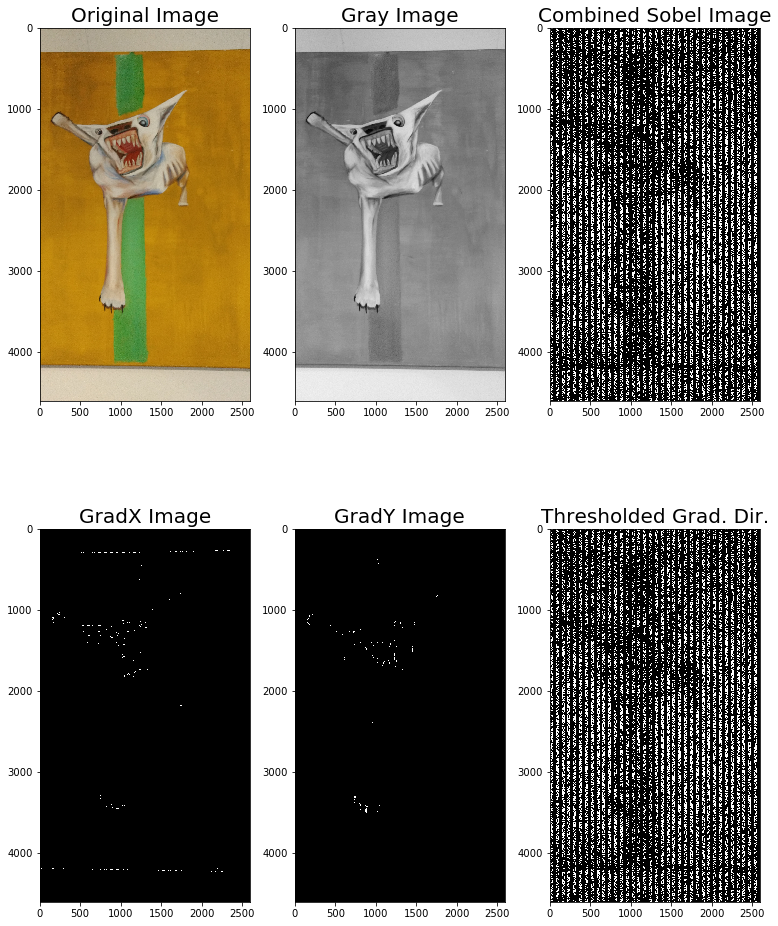

In [36]:
# Plot the result
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(10, 15))
f.tight_layout()
ax1.imshow(im)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(gray, cmap='gray')
ax2.set_title('Gray Image', fontsize=20)
ax3.imshow(rgb_combined, cmap='gray')
ax3.set_title('Combined Sobel Image', fontsize=20)
ax4.imshow(gradx, cmap='gray')
ax4.set_title('GradX Image', fontsize=20)
ax5.imshow(grady, cmap='gray')
ax5.set_title('GradY Image', fontsize=20)
ax6.imshow(((mag_binary == 1) & (dir_binary == 1)), cmap='gray')
ax6.set_title('Thresholded Grad. Dir.', fontsize=20)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show() 

## 2. Prueba en Videos

In [37]:
def process_image(image):
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = gaussian_blur(gray, kernel = 5)
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(50, 100))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(50, 100))
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(20, 100))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(0, np.pi/4))
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    
    rgb_combined = np.asarray(np.dstack((combined, combined, combined)), dtype=np.uint8)
    
    retval, threshold = cv2.threshold(rgb_combined, 0, 255, cv2.THRESH_BINARY)
    
    return threshold

In [ ]:
filter_output = 'Batman_Filter.mp4'
clip1 = VideoFileClip("Batman.mp4")
batman_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time batman_clip.write_videofile(filter_output, audio=False)

[MoviePy] >>>> Building video Batman_Filter.mp4
[MoviePy] Writing video Batman_Filter.mp4


  8%|██████▎                                                                        | 21/265 [15:00<2:56:25, 43.38s/it]

In [ ]:
HTML("""
<video width="720" height="480" controls>
  <source src="{0}">
</video>
""".format(filter_output))

In [ ]:
cap = cv2.VideoCapture(0)  # 0 for Python 3, 1 for Python 2. No idea why?!!

out = cv2.VideoWriter("output.avi", cv2.VideoWriter_fourcc(*"MJPG"), 20,(640,480))

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret==True:
        frame = cv2.flip(frame,180)
        new_frame = process_image(frame)
        out.write(new_frame)

        cv2.imshow('frame',new_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

# Release everything if job is finished
cap.release()
out.release()
cv2.destroyAllWindows()